**这部分的代码将：**

1.读取原始数据，呈现原始数据的分布情况

2.划分训练集与测试集，并呈现测试集与训练集的分布情况

#### 0.载入包和初始化

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt


C:\Users\Sengoku\AppData\Local\Temp\ipykernel_38904\819081168.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
N_out =2
N_in = 2
#输入通道：2（刺激1/刺激2）
#输出通道：2（匹配/不匹配）

time_slice = 100#100ms为一个时间片段
onset = int(500/time_slice)
stim_dur = int(200/time_slice)
blank = int(1500/time_slice)

stim_noise = 0.03
alpha = 1
print("onset is {},stimu_dur is {}".format(onset,stim_dur))

onset is 5,stimu_dur is 2


#### 1.读取数据，查看数据形状

In [3]:
root_path = 'C:/GitHub/FSNet/1.code/data'
df_data = pd.read_csv(root_path + '/Exp1_postpro.csv')
df_data = df_data[df_data['condition'] == 'simultaneous']
df_data.describe()
# 需要用到 rt列

,subj_idx,gender,year,education,dist,rt,ACC,trial_id
count,9544.000000,9544.000000,9544.000000,9544.000000,9544.000000,9544.000000,9544.000000,9544.000000
mean,20.461337,0.550084,2000.952640,5.075545,538.861025,709.318630,0.924560,120.639669
std,11.540940,0.497511,1.805443,0.412593,82.754955,153.445271,0.264114,69.246547
min,1.000000,0.000000,1995.000000,4.000000,396.170000,203.000000,0.000000,1.000000
25%,10.000000,0.000000,2000.000000,5.000000,454.730000,608.000000,1.000000,61.000000
50%,20.000000,1.000000,2001.000000,5.000000,529.130000,681.000000,1.000000,121.000000
75%,30.000000,1.000000,2002.000000,5.000000,596.570000,781.000000,1.000000,181.000000
max,40.000000,1.000000,2004.000000,7.000000,732.870000,1496.000000,1.000000,240.000000


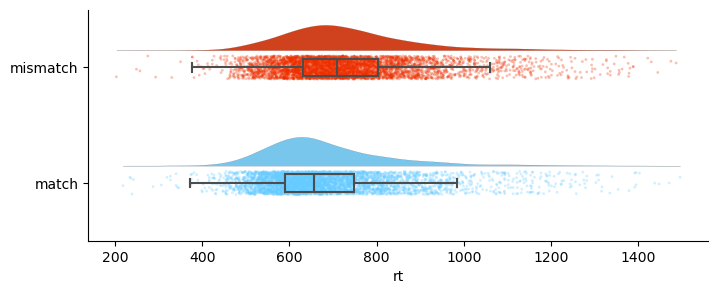

In [4]:
colors_palette = ['#ee3000','#66ccff']

f, ax=plt.subplots(figsize=(8, 3))
ax=pt.half_violinplot(y='matchness', x='rt', data=df_data, bw=.2,
                      cut=0., scale="area", width=.5, inner=None, orient='h',linewidth = 0.1,palette=colors_palette)
ax=sns.stripplot(x='rt', y='matchness', data=df_data, 
                 edgecolor="white", size=2, jitter=1, zorder=0, orient='h',alpha =0.3,palette=colors_palette)
ax=sns.boxplot(x='rt', y='matchness', data=df_data, color="grey", width=.15, zorder=10,
               showcaps=True, boxprops={'facecolor':'none',"zorder":10},
               showfliers=False,
               saturation=1, orient='h')
ax.set_ylabel("")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### 2.数据转换部分
##### get_params()函数：可以将原始数据的一个试次的rt值和match值转化为一个试次的参数

In [5]:
def get_params(row):
    scale = 1
    params = dict()
    if row[-2] == 'match':
        params['matchness'] = 1
    else:
        params['matchness'] = 0

    params['RT'] = row[6]

    chan_1 = 0
    chan_2 = 0
    img = row[-8]
    txt = row[-6]
    if img == '圆形':
        chan_1 = 1
    elif img =='方形':
        chan_1 = 2
    elif img == '三角':
        chan_1 = 3
    else:
        print('waht??')

    if txt == 'circle':
        chan_2 = 1
    elif txt =='square':
        chan_2 = 2
    elif txt == 'triangle':
        chan_2 = 3
    else:
        print('waht2??')

    params['chan_1'] =chan_1
    params['chan_2'] =chan_2

    params['correct'] = row[-9]

    params['noise'] = np.random.exponential(scale)/5

    return params


In [6]:

#随机展示一个试次参数
index = random.randint(1,200)
trail = df_data.iloc[index]
get_params(trail)

C:\Users\Sengoku\AppData\Local\Temp\ipykernel_38904\2722860018.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[-2] == 'match':
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_38904\2722860018.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params['RT'] = row[6]
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_38904\2722860018.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = row[-8]
C:\Users\Sengoku\AppData\Local\

{'matchness': 1,
 'RT': 430,
 'chan_1': 1,
 'chan_2': 1,
 'correct': True,
 'noise': 0.05796590260083363}

##### generate_stimulus()函数：从试次参数生成时间序列的试次数据

In [7]:
rt_list = []
rt_match = []
rt_mis = []
correct_list = []
correct_match = []
correct_mis = []
def generate_stimulus(df_data):
    dataset = []
    for index , row in df_data.iterrows():
        x_list = []
        y_list = []
        # mask_list =[]
        params = get_params(row)
        correct = params['correct']
        matchness = params['matchness']
        chan_1 = params['chan_1']
        chan_2 = params['chan_2']
        noise = params['noise']
        rt = params['RT']
        delay = rt/time_slice
        
        correct_list.append(correct)
        if matchness == 1:
            correct_match.append(correct)
        else:
            correct_mis.append(correct)
        

        rt_list.append(rt)
        if matchness == 1:
            rt_match.append(rt)
        else:
            rt_mis.append(rt)
        
        do = 0
        for time in range(int(onset + stim_dur+blank)):
            x_t = list(np.sqrt(2*alpha*stim_noise*stim_noise)*np.random.randn(N_in))
            y_t = list(np.zeros(N_out))
            if onset <= time < onset + stim_dur:
                x_t[0] += chan_1 + noise
                x_t[1] += chan_2 + noise
                
           
            if time >= onset + stim_dur + delay - 1:
                do = 1
                if str(correct) == 'True':
                    y_t[matchness] = 1.
                else:
                    y_t[(matchness+1)%2] = 1.
            x_list.append(x_t)
            y_list.append(y_t)
        if (do == 0):
            print("not")
            print(delay,onset + stim_dur + delay,row)
        dataset.append((x_list , y_list))
    return dataset

##### 分割数据集：70%的训练集，30%的测试集

In [8]:
test_num = int(len(df_data)*0.3)
train_num = len(df_data) - test_num

df_shuffled = df_data.sample(frac=1).reset_index(drop=True)
train_set = df_shuffled.head(train_num)
test_set = df_shuffled.iloc[train_num:train_num+test_num]

#保存原始测试数据集
test_set.to_csv('fs_human_test_raw.csv', index=False, float_format='%.2f',header=True)

#转换后数据集
df_train = pd.DataFrame(generate_stimulus(train_set))
rt_list = []
rt_match = []
rt_mis = []
df_test = pd.DataFrame(generate_stimulus(test_set))
#保存转换后数据集
df_train.to_csv('output_fs_human.csv', index=False, float_format='%.2f',header=False)
df_test.to_csv('output_fs_human_test.csv', index=False, float_format='%.2f',header=False)

C:\Users\Sengoku\AppData\Local\Temp\ipykernel_38904\2722860018.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[-2] == 'match':
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_38904\2722860018.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params['RT'] = row[6]
C:\Users\Sengoku\AppData\Local\Temp\ipykernel_38904\2722860018.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = row[-8]
C:\Users\Sengoku\AppData\Local\

#### 3.数据展示
##### 编码后的数据时间序列

[[-0.028563668882928935, -0.011087878640185067], [-0.028932067225854237, -0.023139750248065038], [-0.039008827511861986, 0.041191090231123655], [-0.07366739807110818, 0.06070262093063779], [0.09342067718606546, -0.013247227313705619], [1.2028648044994104, 1.2209662045561651], [1.1486873935026551, 1.187514237881642], [0.024121183714201827, -0.02420873439744971], [0.01118894012200289, -0.1414791898730012], [0.014214697140131231, 0.02995840602251359], [-0.021410717549795316, -0.03220147840863786], [-3.5789093969927535e-05, 0.045299671087039], [-0.031155898597116125, -0.01201699746866963], [0.0004067937936145961, -0.028876247085312137], [0.03125810531461833, -0.06441649496591939], [-0.01804337572554196, 0.08575847596838003], [0.017946780908838215, -0.028445328301537013], [-0.04364488563777111, 0.0010113595965654898], [0.04859327049113057, 0.06384185232664064], [-0.07882573810054677, 0.057171612947917956], [0.0316875108253929, -0.004990420343207704], [-0.02269434465904319, 0.009498345742917

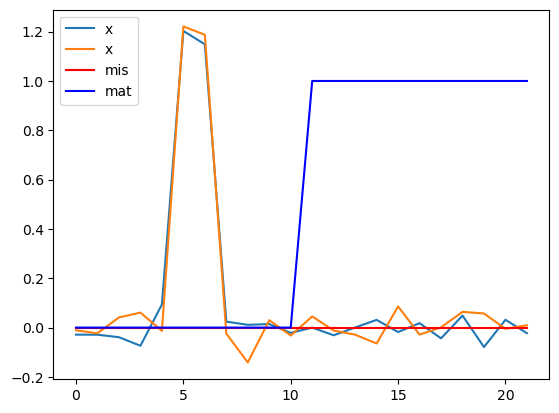

In [9]:
index = random.randint(1,200)
# trail = df.iterrows()
trail = df_train.iloc[index]
print(trail[0])

# x_list , y_list, mask_list = generate_stimulus(df)
x_list = trail[0]
y_list = trail[1]

plt.plot(x_list,label = 'x')
#为list的两个维度分别绘制曲线


plt.plot(np.array(y_list)[:,0],label = 'mis',color = 'red')
plt.plot(np.array(y_list)[:,1],label = 'mat',color = 'blue')
plt.legend()
plt.show()

##### 反应时分布图

acc is 0.9245599329421627,acc_match is 0.9261197153620762,acc_mis is 0.9229962232480067
rt_mean is 711.1645127488648,rt_std is 150.72417750917543
rt_max is 1487,rt_min is 218
Skewness: 1.1483055730364908
Kurtosis: 5.358794857635699


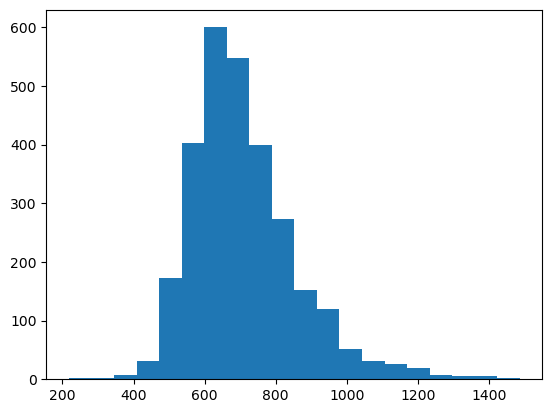

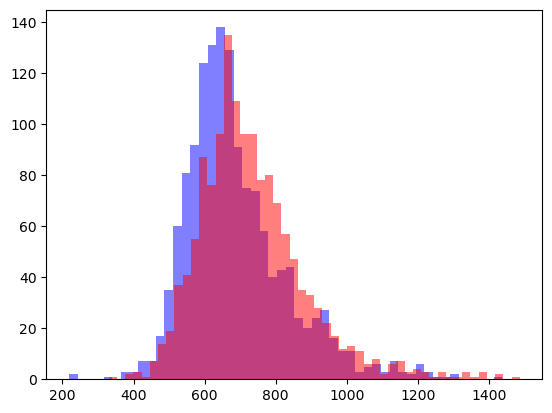

In [10]:
rt_max = np.max(rt_list)
rt_min = np.min(rt_list)
data = rt_list
# 计算均值和标准差
mean = np.mean(data)
std_dev = np.std(data)

acc = np.mean(correct_list)
acc_match = np.mean(correct_match)
acc_mis = np.mean(correct_mis)

print("acc is {},acc_match is {},acc_mis is {}".format(acc,acc_match,acc_mis))

# 计算偏度
skewness = np.mean(((data - mean) / std_dev) ** 3)

# 计算峰度
kurtosis = np.mean(((data - mean) / std_dev) ** 4)

# 输出结果
print("rt_mean is {},rt_std is {}".format(mean,std_dev))
print("rt_max is {},rt_min is {}".format(rt_max,rt_min))
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)


#绘制反应时的分布
plt.hist(rt_list,bins = 20)
plt.show()
plt.hist(rt_match,bins = 50,alpha = 0.5,color='blue')
plt.hist(rt_mis,bins = 50,alpha = 0.5,color='red')
plt.show()

[[-0.023397106595909743, -0.009150333116774372], [-0.027873080939720043, -0.057878923072382106], [0.03340594176627769, 0.010177466363595828], [-0.07197002126952147, 0.09029735358902893], [0.07052224104342796, -7.203368752222924e-05], [2.018982284746996, 3.929858491698334], [1.9532283329424156, 3.9659607293771106], [0.003434672609786816, 0.01713154762325725], [0.03347104050801912, 0.025757261765920067], [-0.017504014185693507, 0.022729053039958848], [0.03949465339872244, 0.03297443209913653], [0.01844761236069308, 0.02710562381254416], [-0.028553284989546478, 0.010336140571536782], [-0.04832090683322292, -0.014711099604403149], [0.0018950652305355744, 0.06458530404223217], [-0.0025474924197810295, -0.0096997306162404], [0.018668623610984734, -0.0198833115541793], [0.02191570516823058, 0.013791700070242026], [0.02026438589664992, 4.6713307512635695e-05], [-0.036040965858859866, 0.05621335834262073], [-0.007811051775913138, -0.044181782380494986], [0.00552310375470341, -0.0114736857636708

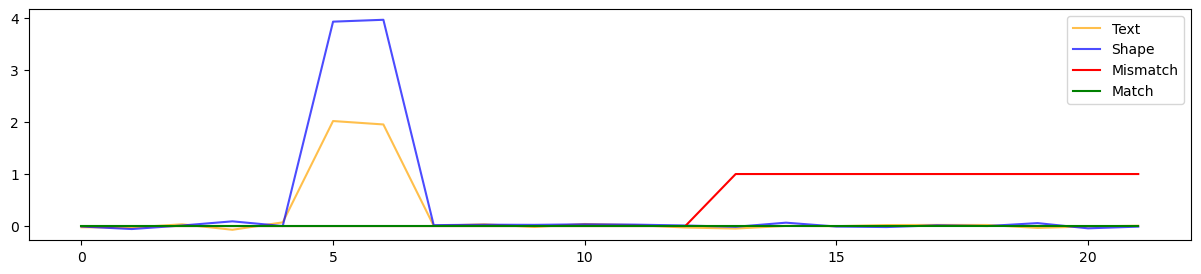

In [11]:
index = random.randint(1,200)
# trail = df.iterrows()
trail = df_train.iloc[index]
print(trail[0])

# x_list , y_list, mask_list = generate_stimulus(df)
x_list = trail[0]
y_list = trail[1]

print(np.array(y_list)[:,0])

#给plt设置尺寸
plt.figure(figsize=(15,3))
plt.plot(np.array(x_list)[:,0],label = 'Text',color = 'orange',alpha = 0.7)
plt.plot(np.array(x_list)[:,1],label = 'Shape',color = 'blue',alpha = 0.7)
#为list的两个维度分别绘制曲线
plt.plot(np.array(y_list)[:,0],label = 'Mismatch',color = 'red')
plt.plot(np.array(y_list)[:,1],label = 'Match',color = 'green')
plt.legend()
plt.show()